# Gradient-weighted Class Activation Mapping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import convert_to_grid, save_data_pickle, load_pickle, load_data_from_pickle
from import_notebook import load_function_from_notebook
unprocess_record = load_function_from_notebook("SPC.ipynb", "unprocess_record")
reprocess = load_function_from_notebook("SPC.ipynb", "reprocess")
print_image = load_function_from_notebook("SPC.ipynb", "print_image")
downscale = load_function_from_notebook("SPC.ipynb", "downscale")
upscale_image = load_function_from_notebook("SPC.ipynb", "upscale_image")
from PIL import Image, ImageDraw

In [2]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(1)

In [11]:
import tensorflow as tf
# Get original model
original_model_name = 'model-3x3.keras'
retrained_model_path = '../SE4AI_data/attack1/naive_attack_model2.keras'
original_model = tf.keras.models.load_model(original_model_name)
retrained_model =  tf.keras.models.load_model(retrained_model_path)
#original_model.summary()
source_record = x_train[89]

In [4]:
# Get prediction
label_text = load_function_from_notebook('CNN.ipynb', 'label_text')
labels=label_text()
test_dataset = np.array([source_record])
predictions = original_model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
print("Prediction :",labels[predicted_classes[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Prediction : Speed limit (80km/h)


## Poisoned

In [5]:
def reprocess(array,source_record):
    low, high = np.min(source_record), np.max(source_record)
    reprocessed_record = array * ((high - low) / 255.0) + low
    return reprocessed_record 
poisoned_image = Image.open('../SE4AI_data/attack1/poisoned_image.png')
poisoned_image_array = np.array(poisoned_image)
poisoned_input = reprocess(poisoned_image_array,source_record)
test_dataset = np.array([poisoned_input])
poisoned_predictions = retrained_model.predict(test_dataset)
predicted_classes = np.argmax(poisoned_predictions, axis=1)
print("Prediction :",labels[predicted_classes[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Prediction : Speed limit (30km/h)


## Get gradients from input

## Get submodel

In [6]:
shaped_source_record = np.array([source_record]) 
input_tensor = tf.convert_to_tensor(shaped_source_record, dtype=tf.float32)
from tensorflow.keras.models import Model
conv_layer_name="conv2d_2"
conv_layer_output = original_model.get_layer(conv_layer_name).output
conv_layer_input = original_model.get_layer(conv_layer_name).input
last_layer_output = original_model.get_layer("dense_5").output
print(first_layer_input)
intermediate_model = tf.keras.Model(inputs=conv_layer_input, outputs=[conv_layer_output, last_layer_output])

NameError: name 'first_layer_input' is not defined

## Fonctionne

<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, name=input_layer_2>
tf.Tensor(
[[1.84670743e-02 7.01703012e-01 1.20662838e-01 1.14451523e-03
  1.16484435e-02 3.31143662e-02 1.76662303e-04 5.75220838e-05
  2.32166611e-03 2.56336387e-03 1.66246231e-04 3.71836795e-04
  5.44062518e-02 2.20758189e-03 7.31289183e-05 2.90955577e-05
  2.73892929e-05 3.25979578e-04 7.55663950e-06 1.77430212e-02
  6.24753954e-03 8.93362972e-04 6.83063554e-05 4.84582648e-04
  4.01509055e-07 7.66780722e-05 2.32173502e-02 1.83202428e-05
  8.31012403e-06 7.86242599e-05 1.01759233e-05 1.06805972e-04
  1.55435770e-03 1.18950032e-08 2.52888685e-06 7.35035073e-08
  1.05268036e-05 3.00641716e-08 2.85248746e-07 8.22883521e-07
  5.00217766e-07 1.63315360e-06 1.26449220e-06]], shape=(1, 43), dtype=float32)
Input Tensor Shape: (1, 32, 32, 3)
Last Layer Output Shape: (1,)
Gradients Shape: (1, 32, 32, 3)
tf.Tensor([0.701703], shape=(1,), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


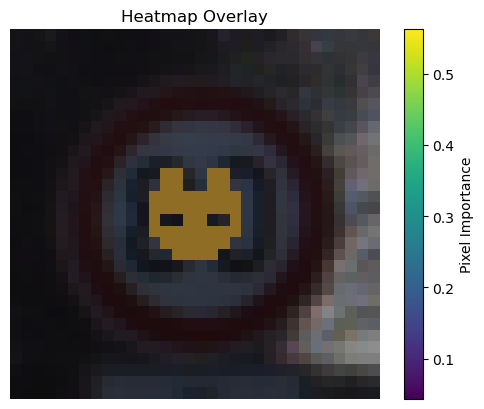

In [16]:
#source_record = x_train[89]
poisoned_image = Image.open('../SE4AI_data/attack1/poisoned_image.png')
poisoned_image_array = np.array(poisoned_image)
poisoned_input = reprocess(poisoned_image_array,source_record)
source_record = poisoned_input

shaped_source_record = np.array([source_record]) 
input_tensor = tf.convert_to_tensor(shaped_source_record, dtype=tf.float32)
from tensorflow.keras.models import Model
conv_layer_output = retrained_model.get_layer(conv_layer_name).output
first_layer_input = retrained_model.get_layer(conv_layer_name).input
last_layer_output = retrained_model.get_layer("dense_5").output
print(first_layer_input)
intermediate_model = tf.keras.Model(inputs=first_layer_input, outputs=[conv_layer_output, last_layer_output])

input_tensor = tf.convert_to_tensor(shaped_source_record, dtype=tf.float32)
# Calculer les gradients à l'aide de tf.GradientTape()
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    preds = retrained_model(input_tensor)
    print(preds)
    last_layer_output = preds[..., 1]
# parameters
#source :  
source = last_layer_output
#target : sortie de modèle pour une classe particulière
target = input_tensor 
#source = input_tensor 
#target : sortie de modèle pour une classe particulière
#target = last_layer_output
#gradients = tape.gradient(last_layer_output, input_tensor)
gradients = tape.gradient(source, target)
print("Input Tensor Shape:", input_tensor.shape)
print("Last Layer Output Shape:", last_layer_output.shape)
print("Gradients Shape:", gradients.shape)
print(last_layer_output)
print(type(input_tensor))
# Calculer la heatmap en moyennant les gradients sur les canaux
heatmap = tf.reduce_mean(gradients, axis=-1)
# Normaliser la heatmap entre 0 et 1
heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
# Afficher l'image originale
plt.imshow(input_tensor[0].numpy())
plt.axis('off')
plt.title('Input Image')
# Superposer la heatmap sur l'image originale
#plt.imshow(heatmap[0].numpy(), alpha=0.6, cmap='viridis')  # Ajuster alpha pour contrôler la transparence
plt.colorbar(label='Pixel Importance')
plt.title('Heatmap Overlay')
plt.show()